In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numba import njit

In [23]:
##################### ASSING_ACTIVITY ###############################

@njit
def Assign_Activity(eps1, eps2, gamma):
    rand = np.random.uniform(0, 1)
    power_rand = (eps1**(1-gamma) + (eps2**(1-gamma) - eps1**(1-gamma)) * rand)**(1/(1-gamma))
    return power_rand

#################### PROBABILITY_DISTRIBUTION_OPINION ###############

@njit
def Probability_Distribution_Opinion(G, numb_node, T, beta, Phi):
    # Calculates probability of node numb_node connecting to each other node.
    N = len(G)
    prob = np.zeros(N)

    # Calculate Norm
    norm = 0
    for i in range (N):
        #sp = 0
        distance = 0
        if i != numb_node: 
            # numb_node is the number of the selected node
            for u in range (T):
                for v in range (T):
                    distance += (G[i][u] - G[numb_node][u]) * (G[i][v] - G[numb_node][v]) * Phi[u][v]
            norm += np.sqrt(abs(distance))**(-beta)
        

    # Calculate Probability of contact
    for i in range (N): 
        if i != numb_node:
            #sp = 0
            distance = 0
            for u in range (T):
                for v in range (T):
                    distance += (G[i][u] - G[numb_node][u]) * (G[i][v] - G[numb_node][v]) * Phi[u][v]
            prob[i] = (np.sqrt(abs(distance))**(-beta) / norm)
    return prob
    
#################### ODEs ###########################################

@njit
def ODEs(N, T, A, K, alpha, Phi, current_opinions, opinions_step):
    # Determine social influence to return the differential. current_opinions and opinions_step
    # are arrays of the form [..., [agent_i_op1, agent_i_op2], [agent_i+1_op1, agent_i+1_op2], ...]
    influence = np.zeros((N,T))
    for i in range (N):
        for o in range (T):
            # Go through connected agents of i
            count = 0
            while A[i][count] != N+1:
                influence[i][o] += np.tanh(alpha * np.dot(Phi, current_opinions[A[i][count]])[o])
                count += 1

    #return differential
    dxdt = -opinions_step + K * influence
    return dxdt

#################### RK4 #############################################

@njit
def RK4(G, T, A, K, alpha, Phi, dt):
    N = len(G)
    # Save current opinions
    current_opinions = np.zeros((N,T))
    for i in range (N):
        for j in range (T):
            current_opinions[i][j] += G[i][j]

    # Calculate ks
    k1 = dt * ODEs(N, T, A, K, alpha, Phi, current_opinions, current_opinions)
    k2 = dt * ODEs(N, T, A, K, alpha, Phi, current_opinions, current_opinions + 0.5 * k1)
    k3 = dt * ODEs(N, T, A, K, alpha, Phi, current_opinions, current_opinions + 0.5 * k2)
    k4 = dt * ODEs(N, T, A, K, alpha, Phi, current_opinions, current_opinions + k3)

    # Calculate total change and update opinions
    k = 1/6 * (k1 + 2*k2 + 2*k3 + k4)
    current_opinions += k
    for i in range (N):
        for j in range (T):
            G[i][j] = current_opinions[i][j]
    




##################### OPINION_DYNAMICS ################################

def Opinion_Dynamics(N, T, m, K, alpha, beta, gamma, Phi, eps1, eps2, runtime_net, runtime_op, dt, filename, times_zero, frac_act):
    # Parameters N to eps1 are the same as in the paper introducing the model. Eps2 is the upper bound for activity,
    # runtime_net is the number of times a new AD-network is formed, runtime_op is the number of opinion-iterations
    # performed on that network. Default is runtime_op = 1. dt is the integration time-step and filename is a string
    # containing the name of the file in which the opinion dynamcis of the agents are saved (filename.csv).

    # Create array to save opinions of all agents after every network-iteration
    save = np.zeros((runtime_net * T + 1, N))

    G = np.zeros((N,T+2))
    # Give each array entry (node) a number, save in array G_num
    G_num = np.arange(0,N)

    # Initialize Activity and Opinions of Nodes
    for i in range (N):
        G[i][T] = Assign_Activity(eps1, eps2, gamma)
        G[i][T+1] = i
        for j in range (T):
            G[i][j] = np.random.normal(0, np.sqrt(2.5))
    # Save activities of agents in first row of save

    for i in range (N):
        save[0][i] += G[i][T]

    # Sorting and finding top active nodes
    act = np.floor(float(N)*frac_act)
    G_sorted = G[np.argsort(G[:,T])]

    # Perform Iterations until runtime_net is reached
    iteration_net = 0
    while iteration_net < runtime_net:

        # Setting top active fraction to 0 at certain time
        if iteration_net in times_zero:
            print("Iteration: ", iteration_net)
            it = 0
            while it < act:
                # Updating opinions
                numb = int(G_sorted[N-1 - it][T+1])
                for i in range (T):
                    # Opinion values can´t be set to exactly zero, since the distance between nodes becomes 0 thus p_ij -> \infty
                    G[numb][i] = np.random.uniform(-1e-10,1e-10)
                it += 1
        

        # Form adjecency array for timestep. Array entry i contains all adjacent nodes of i. Other values are initialized with N+1
        # as a breaking value so ODEs doesn´t go through the whole array
        A = np.full((N,N), N+1)
        # Create counter array to place adjacent nodes correctly in array
        count_arr = np.zeros(N, dtype=int)

        for i in range (N):
            # Go through nodes and possibly activate them
            rand = np.random.uniform(0,1)
            if rand <= G[i][T]:
                # Pick m other nodes randomly. No exception of i needed, since
                # P_D_O excludes i already
                prob = Probability_Distribution_Opinion(G, i, T, beta, Phi)
                picks = np.random.choice(G_num, m, replace=False, p=prob)
                #Update adjacency list: append nodes j to i´s place and vice versa
                for j in picks:
                    A[i][count_arr[i]] = j
                    A[j][count_arr[j]] = i
                    count_arr[i] += 1
                    count_arr[j] += 1
        
        # Calculate the influence of the nodes on eachother
        iteration_op = 0
        while iteration_op < runtime_op:
            # Update opinions via Runge-Kutta 4
            RK4(G, T, A, K, alpha, Phi, dt)
            # increase iteration
            iteration_op += 1
        
        # Save opinions of agents
        for i in range (N):
            for j in range(T):
                # first row of save contains activities. After that for each iteration there´s a row for each iteration,
                # i.e. for two opinions two rows per iteration. 
                save[(T*iteration_net)+j+1][i] += G[i][j]
        
        iteration_net += 1

    # Export save to csv
    # Create column indices (optional)
    nodes_ind = []
    for i in range (N):
        nodes_ind.append(f'Node_{i}')
    # Create row indices (optional)
    op_ind = []
    op_ind.append('activity')
    for i in range (runtime_net):
        for j in range (T):
            op_ind.append(f'iteration {i} op {j}')
    # Create Dataframe and convert it to .csv
    df = pd.DataFrame(save, columns = nodes_ind, index = op_ind)
    df.to_csv (f'D:\Daten mit Änderungen\Physik\Bachelorarbeit\Generated_Data\{filename}.csv', index = False, header = False)

    return 0
        
            



In [66]:
N = [1000] # 1000 nodes should be the minimum, below initial fluctuations take over and polarization becomes instable
T = 2
m = [10] # np.floor(N+50/100)
K = 3
alpha = 2.0
beta = 3.0
gamma = 2.1
Phi = np.array([[1.0,0.0],[0.0,1.0]])
eps1 = 0.01
eps2 = 1.0
runtime_net = 1000 # Stability is reached from about 500 iterations
runtime_op = 1
step = 0.01
times_zero = np.arange(0,runtime_net, 25)
frac = 0.1
print("m: ", m)
print("Phi: ", Phi[0][0], Phi[0][1], Phi[1][0], Phi[1][1])
# File Names should be a 2-dim array with the first dimension being for each wanted value of a parameter
# and the second dimension full of array names for the multiple simulations.
File_Names = [['trying_out_frac']]
# SETTING TO ZERO MULTIPLE TIMES

m:  [10]
Phi:  1.0 0.0 0.0 1.0


In [67]:
for i in range (len(File_Names)):
    for j in range (len(File_Names[i])):
        Opinion_Dynamics(N[i], T, m[i], K, alpha, beta, gamma, Phi, eps1, eps2, runtime_net, runtime_op, step, File_Names[i][j], times_zero, frac)

Iteration:  0
Iteration:  25
Iteration:  50
Iteration:  75
Iteration:  100
Iteration:  125
Iteration:  150
Iteration:  175
Iteration:  200
Iteration:  225
Iteration:  250
Iteration:  275
Iteration:  300
Iteration:  325
Iteration:  350
Iteration:  375
Iteration:  400
Iteration:  425
Iteration:  450
Iteration:  475
Iteration:  500
Iteration:  525
Iteration:  550
Iteration:  575
Iteration:  600
Iteration:  625
Iteration:  650
Iteration:  675
Iteration:  700
Iteration:  725
Iteration:  750
Iteration:  775
Iteration:  800
Iteration:  825
Iteration:  850
Iteration:  875
Iteration:  900
Iteration:  925
Iteration:  950
Iteration:  975


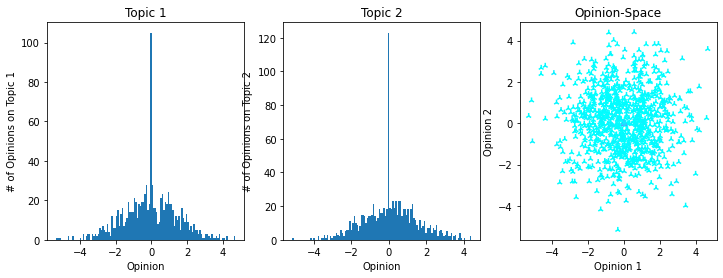

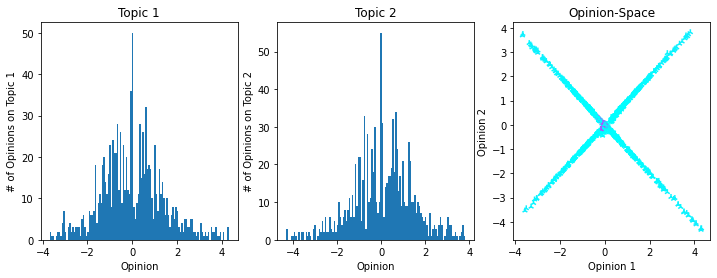

In [68]:
data = np.loadtxt(r'D:\Daten mit Änderungen\Physik\Bachelorarbeit\Generated_Data\trying_out_frac.csv', delimiter=',')

def Plot_Opinion_Distribution_2d(data1, data2, data_act):
    op1_list = data1
    op2_list = data2

    fig, ax = plt.subplots(1,3, figsize=(12,4))
    ax[0].set_title("Topic 1")
    ax[0].set_xlabel("Opinion")
    ax[0].set_ylabel("# of Opinions on Topic 1")
    ax[0].hist(op1_list, bins=120)
    ax[1].set_title("Topic 2")
    ax[1].set_xlabel("Opinion")
    ax[1].set_ylabel("# of Opinions on Topic 2")
    ax[1].hist(op2_list, bins=120)
    ax[2].set_title("Opinion-Space")
    ax[2].set_xlabel("Opinion 1")
    ax[2].set_ylabel("Opinion 2")
    ax[2].scatter(op1_list, op2_list, c=data_act, cmap='cool', marker = '2')
    plt.show()

Plot_Opinion_Distribution_2d(data[1], data[2], data[0])
Plot_Opinion_Distribution_2d(data[len(data)-2], data[len(data)-1], data[0])